In [1]:
#import results of classification from csv and calculate the distances between the cells

import csv

##definition of data location
data = []
#file = '230414_fullslideiba1_scan_211109_resnet.csv'
#file = '20230727_fullslidecd206_scan_211109_resnet18.csv'
path = 'c:/Users/chris/OneDrive/AI/Validation/fullslide_scans/'
fname = '230414_fullslideho1_scan_211109_resnet18_reverse.csv'

file =path +fname

stain = file[16:20]

if stain == 'ho1_':
    stain = 'HO-1'
elif stain == 'iba1':
    stain = 'iba1'
elif stain == 'neDr':
    stain = 'cd206'
    
##load the data
with open(file, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        row_data = []
        for item in row:
            try:
                item = item.strip(' ()')
                item = item.strip('[]')
                item = item.strip('()')
                row_data.append(float(item))
            except ValueError:
                row_data.append(item)
            
        
        data.append(row_data)

# list with Tuples of coordinates in each slide
data2 = []
for row in data:
    row_data = []
    row_data.append(row[0])
    for i in range(3,len(row), 2):
        tuple = (row[i]*20, row[i+1]*20)
        row_data.append(tuple)
        
    data2.append(row_data)

# list with the data of the distance to the neighbor cell    
data_neighbor= []    
for row in data2: 
    slide= row[0]
    #print(slide)
    closest_cell = []
    closest_cell.append(slide)
    for coord in row[1:]:
        distance_neighbor = 1000000
        for coord_ref in row[1:]:
            distance = ((coord[0]-coord_ref[0])**2 + (coord[1]-coord_ref[1])**2)**0.5
            #factor for calculation of µm from pixels
            distance = distance*0.274909
            if distance >0 and distance <distance_neighbor:
                distance_neighbor = distance
            
        
        closest_cell.append(distance_neighbor)
    data_neighbor.append(closest_cell)

    
print('done')

done


mean by animal
                25. Perzentile  50. Perzentile  75. Perzentile
Genotyp animal                                                
TG      37           41.228523       85.763022      185.190946
        39           63.725358      135.067324      218.064851
        40           45.558247       91.499611      185.044843
        42           70.416224      166.661411      288.839882
        44           53.417276      106.603033      170.957885
WT      36           45.940203       93.266155      185.713371
        38           48.927845       87.558117      162.185740
        41           46.975321       91.816377      217.609167
        43           39.221022       80.949135      140.296053
        45           50.584108       96.557954      207.562815
mean by Genotyp
Genotyp                 TG          WT
25. Perzentile   54.869126   46.329700
50. Perzentile  117.118880   90.029548
75. Perzentile  209.619681  182.673429


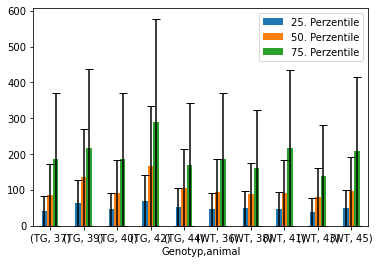

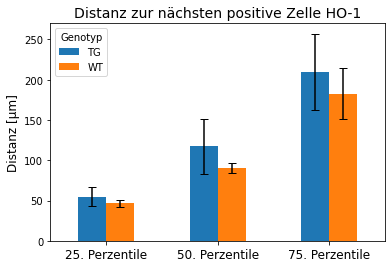

In [16]:
##calculate the median and percentiles based on slides and calculate means from that

import numpy as np
import pandas as pd
#create list of slides

#list with the wildtype numbers
WT = [36,38,41,43,45]

list_slide = []
list_median_slide = []
list_25perc_slide = []
list_75perc_slide = []

for row in data_neighbor:
    list_slide.append(row[0][:7])
    list_median_slide.append(np.median(row[1:]))
    list_25perc_slide.append(np.percentile(row[1:],25))
    list_75perc_slide.append(np.percentile(row[1:],75))

df = pd.DataFrame({'slide': list_slide, '25. Perzentile': list_25perc_slide, '50. Perzentile': list_median_slide, '75. Perzentile': list_75perc_slide})



df['animal'] = df['slide'].str[:2]
df['Genotyp'] = df['animal'].apply(lambda x: 'WT' if int(x) in [36,38,41,43,45] else 'TG')

print('mean by animal')

mean= df.groupby(['Genotyp', 'animal']).mean()

std = df.groupby(['Genotyp', 'animal']).mean()
print(mean)
mean.plot.bar(yerr=std,  capsize=4, rot=0)


print('mean by Genotyp')

mean_genotype = mean.groupby('Genotyp').mean()
mean_genotype = mean_genotype.transpose()
std_genotype = mean.groupby('Genotyp').std()
std_genotype = std_genotype.transpose()
print(mean_genotype)
mean_genotype.plot.bar(yerr = std_genotype, capsize = 4)
plt.title('Distanz zur nächsten positive Zelle HO-1', fontsize = 14)
plt.ylabel('Distanz [µm]', fontsize = 12)
plt.xticks(fontsize =12)
plt.tick_params(axis='x', labelrotation=0)

mean_animal = df.groupby('animal').mean().reset_index()
mean_animal['Genotyp'] = mean_animal['animal'].apply(lambda x: 'WT' if int(x) in [36,38,41,43,45] else 'TG')   


In [4]:
import scipy.stats as stats
#statistics after calculation of mean by slide and animal 

df= mean.reset_index()


df.columns = ['genotype','animal', '25_perc', 'median', '75_perc']
df_genotype =df.groupby('genotype').agg({'median': ['mean', 'std']}).reset_index()
df_genotype_25 =df.groupby('genotype').agg({'25_perc': ['mean', 'std']}).reset_index()
df_genotype_75 =df.groupby('genotype').agg({'75_perc': ['mean', 'std']}).reset_index()


#summarizing df
df_statistics = pd.DataFrame({'genotype': ['mean-WT', 'mean_TG', 'std_WT', 'std_TG', 'shapiro-wilk_WT', 'shapiro-wilk_TG','levenetest', 'ttest']})



#t-test 25 percentile
print('25perc')


groupA = df.groupby('genotype').get_group('WT')['25_perc']
groupB = df.groupby('genotype').get_group('TG')['25_perc']
t_stat, p_value = stats.ttest_ind(groupA, groupB)

# print the results

#Shapiro Wilk


# Test for normal distribution using the Shapiro-Wilk test
_, p1 = stats.shapiro(groupA)
_, p2 = stats.shapiro(groupB)
print('Shapiro-Wilk WT:', p1, 'TG:', p2)



# Test for variance equality using Levene's test
_, p3 = stats.levene(groupA, groupB)
print('levenes test: ', p3)

print('t-statistic:', t_stat)
print('p-value:', p_value)

df_statistics['25perc'] = [np.mean(groupA), np.mean(groupB),np.std(groupA), np.std(groupB),p1, p2, p3, p_value]


#t test median

print('median')
groupA = df.groupby('genotype').get_group('WT')['median']
groupB = df.groupby('genotype').get_group('TG')['median']
t_stat, p_value = stats.ttest_ind(groupA, groupB)

#Shapiro Wilk


# Test for normal distribution using the Shapiro-Wilk test
_, p1 = stats.shapiro(groupA)
_, p2 = stats.shapiro(groupB)
print('Shapiro-Wilk WT:', p1, 'TG:', p2)

# Test for variance equality using Levene's test
_, p3 = stats.levene(groupA, groupB)
print('levenes test: ', p3)


# print the results
print('t-statistic:', t_stat)
print('p-value:', p_value)

df_statistics['50.perc'] = [np.mean(groupA), np.mean(groupB),np.std(groupA), np.std(groupB),p1, p2, p3, p_value]

#t-test 75perc
print('75perc')


groupA = df.groupby('genotype').get_group('WT')['75_perc']
groupB = df.groupby('genotype').get_group('TG')['75_perc']
t_stat, p_value = stats.ttest_ind(groupA, groupB)


#Shapiro Wilk


# Test for normal distribution using the Shapiro-Wilk test
_, p1 = stats.shapiro(groupA)
_, p2 = stats.shapiro(groupB)
print('Shapiro-Wilk WT:', p1, 'TG:', p2)


# Test for variance equality using Levene's test
_, p3 = stats.levene(groupA, groupB)
print('levenes test: ', p3)


# print the results
print('t-statistic:', t_stat)
print('p-value:', p_value)

df_statistics['75perc'] = [np.mean(groupA), np.mean(groupB),np.std(groupA), np.std(groupB),p1, p2, p3, p_value]
df_statistics.columns = ['test', '25.perc', '50.perc','75.perc']
print(df_statistics)


25perc
Shapiro-Wilk WT: 0.05032968893647194 TG: 0.12284114211797714
levenes test:  0.5081380407410452
t-statistic: -0.6545900782200925
p-value: 0.5310966605859255
median
Shapiro-Wilk WT: 0.3011549711227417 TG: 0.18121875822544098
levenes test:  0.5586424003844661
t-statistic: -0.5659297025684401
p-value: 0.5869604791302482
75perc
Shapiro-Wilk WT: 0.3917351961135864 TG: 0.18428465723991394
levenes test:  0.6309282743043252
t-statistic: -0.4467539719382324
p-value: 0.6668992317474468
              test    25.perc     50.perc     75.perc
0          mean-WT  43.750810   85.195245  167.912693
1          mean_TG  55.042125  102.493572  194.826601
2           std_WT  17.199548   33.055934   64.644705
3           std_TG  29.905666   51.424494  101.676228
4  shapiro-wilk_WT   0.050330    0.301155    0.391735
5  shapiro-wilk_TG   0.122841    0.181219    0.184285
6       levenetest   0.508138    0.558642    0.630928
7            ttest   0.531097    0.586960    0.666899


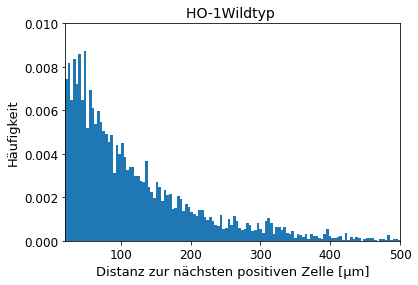

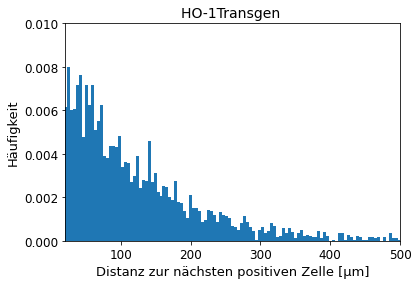

In [8]:

##plot histogramm with all the distribution of the distance to the next cell

#list with the short numbers of the animals

list_animal = []

# list with the data and the animal
data_neighbor_animal = []
#merge distances to the next cell of the different slides

for row in data_neighbor: 
    animal = int(row[0][:2])
    if animal not in list_animal:
        list_animal.append(animal)
        data_neighbor_animal.append([animal]+ row[1:])
    else:
        ind= list_animal.index(animal)
        data_neighbor_animal[ind].extend(row[1:])

#list with the wildtype numbers
WT = [36,38,41,43,45]

# merge by group
data_groups = [['Wildtyp '], ['Transgen ']]
for row in data_neighbor_animal:
    animal = row[0]
    if animal in WT:
        data_groups[0].extend(row[1:])
    else:
        data_groups[1].extend(row[1:])
        
# plot histogram
for row in data_groups: 
    slide = row[0]
    import matplotlib.pyplot as plt

    data = row[1:]

    # create histogram
    plt.hist(data, bins = 500, density = True)
    plt.axis([21, 500, 0, 0.010])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.title('Nearest cell', fontsize=14)
    plt.xlabel('Distanz zur nächsten positiven Zelle [µm]', fontsize = 13)
    plt.ylabel('Häufigkeit', fontsize = 13)

    # set title
    plt.title('HO-1'+row[0], fontsize = 14)

    # display plot
    plt.show()
    
    
    
    #print(len(row))
